# Adding a sampler from scikit-activeml into OpenAL

This notebook is an example attached to our blog post in Data from the trenches (add link). It shows how versatile OpenAL is by adding a sampler from another package.

We use the `DiscriminativeAL` sampler from scikit-activeml. scikit-activeml does sample selection in one go using a `query` method. On our side, we use the cardinal interface that requires 2 methods:
* `fit(X, y)` that processes labelled data
* `select_samples(X, y)` that returns indices of selected unlabeled samples

We write a simple wrapper to call DiscriminativeAL from OpenAL.


In [27]:
import numpy as np
from cardinal.base import BaseQuerySampler
from skactiveml.utils import MISSING_LABEL
from skactiveml.pool import DiscriminativeAL


class WrappedDiscriminativeAL(BaseQuerySampler):
    """Wrapped version of the Quire AL strategy
    Args:
        batch_size: Numbers of samples to select.
    """
    def __init__(self, batch_size: int, classifier):
        super().__init__(batch_size)
        self.classifier = classifier
        self.X = None
        self.y = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        """Fit the model on labeled samples.
        Args:
            X: Labeled samples of shape (n_samples, n_features).
            y: Labels of shape (n_samples).
        
        Returns:
            The object itself
        """

        # Scikit-activeml requires to give labeled and unlabeled at the
        # same time, we store the labeled data.
        
        self.X = X
        self.y = y

        return self


    def select_samples(self, X: np.array) -> np.array:
        """Selects the samples from unlabeled data using the internal scoring.
        Args:
            X: Pool of unlabeled samples of shape (n_samples, n_features).
            strategy: Strategy to use to select queries. 
        Returns:
            Indices of the selected samples of shape (batch_size).
        """
        
        X_ = np.vstack([X, self.X])
        y_ = np.hstack([np.full(X.shape[0], MISSING_LABEL), self.y])
        
        qs = DiscriminativeAL(greedy_selection=True)
        idx = qs.query(X=X_, y=y_, discriminator=self.classifier, batch_size=self.batch_size)

        # Prevent reusing the same data
        self.X = None
        self.y = None
        
        return idx

# Running DiscriminativeAL on dataset 1502

OpenAL comes with its standard benchmark. The name of the tasks are simply the id of the datasets. By using the id `'1502'`, we load the task ran in the paper. We run the exact same experiment!

In [31]:
from bench.experiment import load_experiment, load_initial_conditions, run
from skactiveml.classifier import SklearnClassifier


dataset_id = '1502'

initial_conditions = load_initial_conditions(dataset_id)
experimental_parameters = load_experiment(dataset_id, initial_conditions)
disc_al = {'discriminative_al': lambda params: WrappedDiscriminativeAL(
    params['batch_size'], SklearnClassifier(params['clf']))}
run(experimental_parameters, disc_al)


--- Running experiment 1502 ---

Iteration 0


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]

Already computed. Skipping.
Iteration 1



	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 2


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 3



	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 4


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 5



	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 6


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 7



	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 8


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.
Iteration 9



	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:00<?, ?it/s]


Already computed. Skipping.


	Processing discriminative_al:   0%|                                                                                                                                                                                                                   | 0/10 [00:03<?, ?it/s]


The results of the experiment are saved in the folder `./experiment_results/1502`. We load the accuracy plots to see how DiscriminativeAL performed.

/tmp/ipykernel_23633/3582734669.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


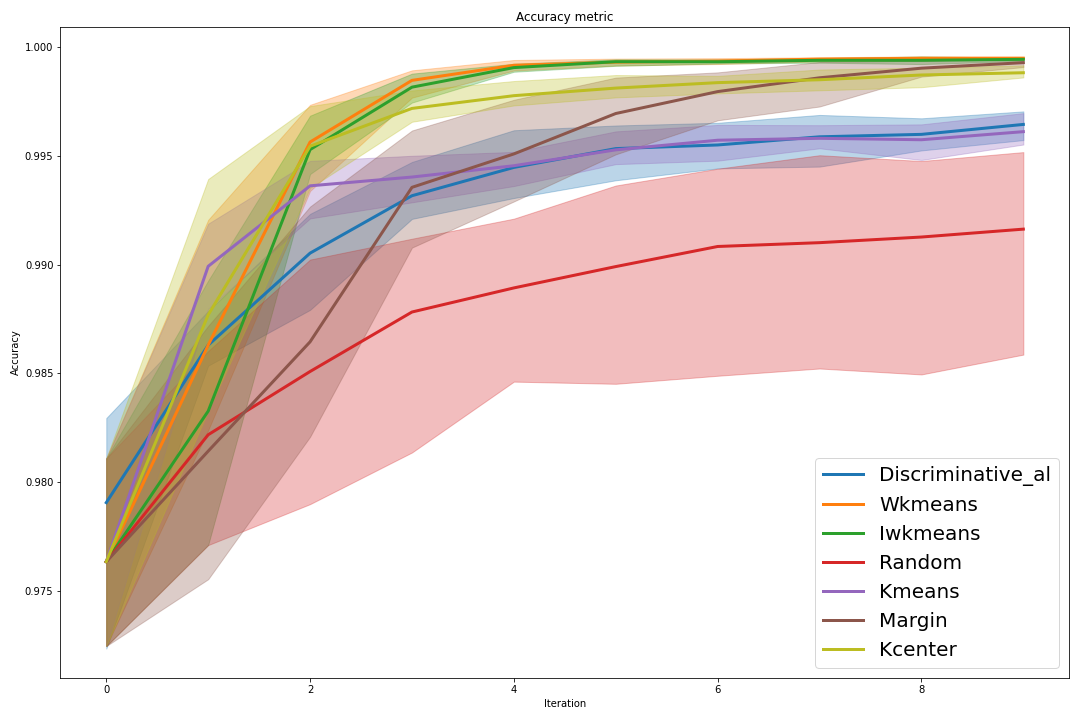

In [29]:
from IPython.core.display import Image, display


display(Image(filename='experiment_results/1502/plots/plot-Accuracy.png'))

DiscriminativeAL is not performing well on this dataset. One reason may be that the greedy version of the sampler is not the best version. However, the non-greedy version is very slow! A good compromise could be to run the sampler by batches of 10% of the batch size!